# Towards Data Science Blog Posts: Jargon Analysis
### Classification  
#### *Attempt to model the relationship between the proportion and frequency of jargon words with the target variable: claps.* 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

import re
from nltk.tokenize import WhitespaceTokenizer

import warnings
warnings.filterwarnings('ignore')

In [36]:
filename =  '../data/tds_vectorized_jargon.csv'

In [37]:
df = pd.read_csv(filename)

In [38]:
df.head()

,claps,text,A/B testing,accuracy,action,activation function,active learning,AdaGrad,agent,agglomerative clustering,...,user matrix,validation,validation set,vanishing gradient problem,Wasserstein loss,weight,Weighted Alternating Least Squares (WALS),wide model,width,total_jargon_count
0,489,ultimate guide acing coding interviews data sc...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
1,139,shakespeare versus eminem— who’s better lyrici...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,8
2,133,implementing visualttransformer pytorch hi guy...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,42
3,92,stock price analysis pandas altair practical g...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
4,58,optimal threshold imbalanced classification ha...,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,145


In [39]:
#sort df before transformation
df = df.sort_values(by = ['claps', 'text'], ascending=False, ignore_index=True)

#### Transform the Target into a Binary Variable

In [40]:
#establish a threshold for 'high engagement' of mean plus one standard deviation
thresh = df['claps'].mean() + df['claps'].std()
thresh

208.91182371361316

In [41]:
#check how many posts meet that criterion
(df['claps'] >= thresh).sum()

1122

In [42]:
claps = [1 if clap >= thresh else 0 for clap in df['claps']]

In [43]:
df['claps'] = claps

In [44]:
df['claps'].value_counts(normalize=True)

0    0.879225
1    0.120775
Name: claps, dtype: float64

### Investigation I: Effect of Proportion of Jargon on Number of Claps

In [45]:
df['total_jargon_count'].head()

0    18
1    87
2    13
3    21
4    43
Name: total_jargon_count, dtype: int64

In [46]:
#read in preprocessed abstracts to get total word count
tds = pd.read_csv('../data/tds_nltk_stemmed_preproc.csv').drop(columns = 'Unnamed: 0')

In [47]:
#get both dataframes in the same order

tds = tds.sort_values(by = ['claps', 'text'], ascending=False, ignore_index=True)

In [48]:
#remove punctuation characters 
tds['text'] = tds['text'].replace("[''·,\.!?'-]",'',regex=True)
#remove brackets surrounding the text
tds['text'] = tds['text'].map(lambda x: x.replace("[",""))
tds['text'] = tds['text'].map(lambda x: x.replace("]",""))

In [49]:
#tokenize text into lists to get word count
w_tokenizer = WhitespaceTokenizer()
tds['text'] = tds['text'].apply(lambda x: w_tokenizer.tokenize(x))

In [50]:
# calculate word count, jargon count, and jargon proportion 
word_count = tds['text'].apply(lambda x: len(x))
jargon_count = df['total_jargon_count']

jargon_prop = (jargon_count/word_count)

In [51]:
#Create new dataframe with jargon prop and citations
prop = pd.DataFrame()
prop['jargon_prop'] = pd.Series(jargon_prop)
prop['claps'] = df['claps']

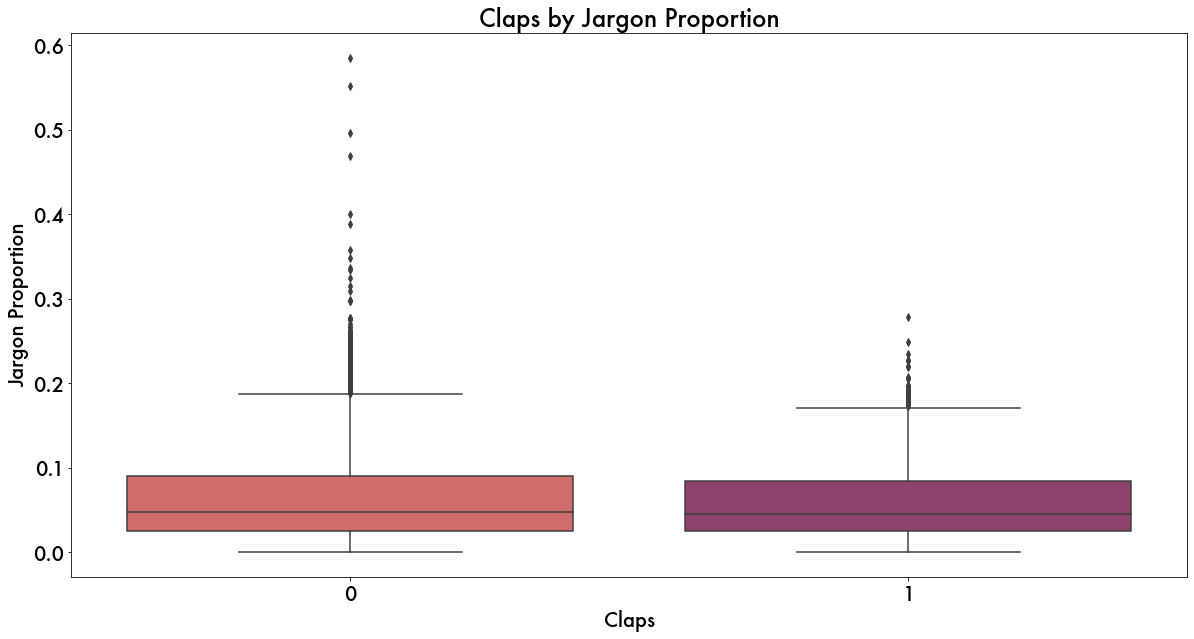

In [52]:
plt.figure(figsize = (20, 10));
sns.boxplot(data=prop, x='claps', y = 'jargon_prop', palette='flare');
figurefont = {'fontname' : 'Futura'};
plt.title('Claps by Jargon Proportion', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Claps',**figurefont, fontsize = 20);
plt.ylabel('Jargon Proportion',**figurefont, fontsize = 20);
plt.savefig('../figures/tds_claps_jargon_class_boxplot.jpg',  bbox_inches = "tight")

### Investigation Attempt II: Classification Modeling 

In [53]:
#confirm no nulls 
df.isnull().sum().sum()

0

In [54]:
X = df.drop(columns=['claps','text'])
y = df['claps']

In [55]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                  stratify=y,
                                                 random_state=42)

#### Run Through Classifiers

In [56]:
model_list = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    BaggingClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    SVC(),
    BernoulliNB()
]

results_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj
   
    #fit the model
    model.fit(X_train, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train, y_train)
    results_dict['test_score'] = model.score(X_test, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train, y_train, cv = 5).mean()
    results_dict['precision_score'] = precision_score(y_test, model.predict(X_test))
    results_dict['train_f1_score'] = f1_score(y_train, model.predict(X_train))  
    results_dict['test_f1_score'] = f1_score(y_test, model.predict(X_test))  
    
    #add the dictionary to the list
    results_list.append(results_dict)

In [57]:
results = pd.DataFrame(results_list)
results

,model_name,train_score,test_score,cv_score,precision_score,train_f1_score,test_f1_score
0,LogisticRegression(),0.879575,0.876211,0.875942,0.200000,0.026115,0.017094
1,DecisionTreeClassifier(),0.999058,0.803552,0.795344,0.138462,0.996087,0.128878
2,BaggingClassifier(),0.977260,0.871905,0.872443,0.208333,0.896509,0.040323
3,RandomForestClassifier(),0.999058,0.876749,0.879037,0.000000,0.996087,0.000000
4,AdaBoostClassifier(),0.879575,0.877287,0.874866,0.300000,0.032432,0.025641
5,SVC(),0.879171,0.879440,0.879171,0.000000,0.000000,0.000000
6,BernoulliNB(),0.850242,0.833154,0.843246,0.135593,0.148432,0.093567


None of these models are better than baseline at predicting whether a post will get an above-average number of claps or not.